##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Adversarial Interpretability

This colab notebook is a starter notebook merging interpretability techniques from  [**Building Blocks of Interpretability**](https://distill.pub/2018/building-blocks) with the field of adversarial example research. This is a current stream of work for a distill article -- please contact **dhruv (dot) guliani (at) gmail (dot) com** if you would like to get involved.

This notebook uses **semantic dictionaries** and **activation grids** that interpret spatial activation vectors to better understand how an adversarial attack unfolds on a network. 

This tutorial is based on [**Lucid**](https://github.com/tensorflow/lucid), a network for visualizing neural networks. Lucid is a kind of spiritual successor to DeepDream, but provides flexible abstractions so that it can be used for a wide range of interpretability research.

**Note**: The easiest way to use this tutorial is [as a colab notebook](), which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

Thanks for trying Lucid!


# Install / Import / Load

This code depends on [Lucid](https://github.com/tensorflow/lucid) (our visualization library), and [svelte](https://svelte.technology/) (a web framework). The following cell will install both of them, and dependancies such as TensorFlow. And then import them as appropriate.

In [11]:
!pip install --quiet lucid==0.0.5
!pip install cleverhans
!npm install -g svelte-cli@2.2.0
#tensorflow_version only works on colab
%tensorflow_version 1.x


import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('1')
import scipy.ndimage as nd

import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
import lucid.optvis.param as param
import lucid.optvis.objectives as objectives
import lucid.optvis.transform as transform

from lucid.misc.io import show, load
from lucid.misc.io.reading import read
from lucid.misc.io.showing import _image_url
from lucid.misc.channel_reducer import ChannelReducer

import lucid.scratch.web.svelte as lucid_svelte

from google.colab import files

/tools/node/bin/svelte -> /tools/node/lib/node_modules/svelte-cli/bin.js
+ svelte-cli@2.2.0
updated 1 package in 0.435s


# Setup Code

## **Defining the interface**

First, we define our "semantic dictionary" interface as a [svelte component](https://svelte.technology/). This makes it easy to manage state, like which position we're looking at.

In [12]:
%%html_define_svelte SemanticDict

<div class="figure">
    <div class="input_image">
        <div class="image" style="background-image: url({{image_url}}); z-index: -10;"></div>
        <svg class="pointer_container" viewBox="0 0 {{N[0]}} {{N[1]}}">

            {{#each xs as x}}
            {{#each ys as y}}
              <rect x={{x}} y={{y}} width=1 height=1
                class={{(x == pos[0] && y == pos[1])? "selected" : "unselected"}}
                on:mouseover="set({pos: [x,y]})"></rect>
            {{/each}}
            {{/each}}
        </svg>
    </div>
    <div class="dict" >
        {{#each present_acts as act, act_ind}}
        <div class="entry">
            <div class="sprite" style="background-image: url({{spritemap_url}}); width: {{sprite_size}}px; height: {{sprite_size}}px; background-position: -{{sprite_size*(act.n%sprite_n_wrap)}}px -{{sprite_size*Math.floor(act.n/sprite_n_wrap)}}px; --info: {{act.n}};"></div>
            <div class="value" style="height: {{sprite_size*act.v/1000.0}}px;"></div>
        </div>
        {{/each}}
    </div>
    <div class="input_image">
        <div class="image" style="background-image: url({{adv_image_url}}); z-index: -10;"></div>
        <svg class="pointer_container" viewBox="0 0 {{N[0]}} {{N[1]}}">

            {{#each xs as x}}
            {{#each ys as y}}
              <rect x={{x}} y={{y}} width=1 height=1
                class={{(x == pos[0] && y == pos[1])? "selected" : "unselected"}}
                on:mouseover="set({pos: [x,y]})"></rect>
            {{/each}}
            {{/each}}
        </svg>
    </div>
    <div class="dict" >
        {{#each adv_acts as act, act_ind}}
        <div class="entry">
            <div class="sprite" style="background-image: url({{spritemap_url}}); width: {{sprite_size}}px; height: {{sprite_size}}px; background-position: -{{sprite_size*(act.n%sprite_n_wrap)}}px -{{sprite_size*Math.floor(act.n/sprite_n_wrap)}}px; --info: {{act.n}};"></div>
            <div class="value" style="height: {{sprite_size*act.v/1000.0}}px;"></div>
        </div>
        {{/each}}
    </div>
</div>


<style>
    .figure {
        padding: 10px;
        width: 1024px;
    }
    .input_image {
        display: inline-block;
        width: 224px;
        height: 224px;
    }
    .input_image .image, .input_image .pointer_constainer {
        position: absolute;
        width: 224px;
        height: 224px;
        border-radius: 8px;
    }
    .pointer_container rect {
      opacity: 0;
    }
    .pointer_container .selected {
      opacity: 1;
      fill: none;
      stroke: hsl(24, 100%, 50%);
      stroke-width: 0.1px;
    }
    
    .dict {
        height: 128px;
        display: inline-block;
        vertical-align: bottom;
        padding-bottom: 64px;
        margin-left: 64px;
    }
    .entry {
        margin-top: 9px;
        margin-right: 32px;
        display: inline-block;
    }
    .value {
        display: inline-block;
        width: 32px;
        border-radius: 8px;
        background: #777;
    }
    .sprite {
        display: inline-block;
        border-radius: 8px;
    }
    .dict-text {
        display: none;
        font-size: 24px;
        color: #AAA;
        margin-bottom: 20px;
    }
</style>

<script>
    
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        spritemap_url: "",
        sprite_size: 64,
        sprite_n_wrap: 1e8,
        image_url: "",
        activations: [[[{n: 0, v: 1}]]],
        adv_activations: [[[{n: 0, v: 1}]]],
        pos: [0,0]
      };
    },
    computed: {
      present_acts: (activations, pos) => activations[pos[1]][pos[0]],
      adv_acts: (adv_activations, pos) => adv_activations[pos[1]][pos[0]],
      N: activations => [activations.length, activations[0].length],
      xs: (N) => range(N[0]),
      ys: (N) => range(N[1])
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_OPc5QQ/SemanticDict_50e5780.html > /tmp/svelte_OPc5QQ/SemanticDict_50e5780.js
svelte version 1.64.1
compiling ../tmp/svelte_OPc5QQ/SemanticDict_50e5780.html...



## **Spritemaps**

In order to use the semantic dictionaries, we need "spritemaps" of channel visualizations.
These visualization spritemaps are large grids of images (such as [this one](https://storage.googleapis.com/lucid-static/building-blocks/googlenet_spritemaps/sprite_mixed4d_channel.jpeg)) that visualize every channel in a layer.
We provide spritemaps for GoogLeNet because making them takes a few hours of GPU time, but
you can make your own channel spritemaps to explore other models. [Check out other notebooks](https://github.com/tensorflow/lucid#notebooks) on how to
make your own neuron visualizations.

It's also worth noting that GoogLeNet has unusually semantically meaningful neurons. We don't know why this is -- although it's an active area of research for us. More sophisticated interfaces, such as neuron groups, may work better for networks where meaningful ideas are more entangled or less aligned with the neuron directions.

In [0]:
layer_spritemap_sizes = {
    'mixed3a' : 16,
    'mixed3b' : 21,
    'mixed4a' : 22,
    'mixed4b' : 22,
    'mixed4c' : 22,
    'mixed4d' : 22,
    'mixed4e' : 28,
    'mixed5a' : 28,
  }

img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")


def googlenet_spritemap(layer):
  assert layer in layer_spritemap_sizes
  size = layer_spritemap_sizes[layer]
  url = "https://storage.googleapis.com/lucid-static/building-blocks/googlenet_spritemaps/sprite_%s_channel_alpha.jpeg" % layer
  return size, url

layers = ['conv2d%d' % i for i in range(0, 3)] + ['mixed3a', 'mixed3b', 
                                                  'mixed4a', 'mixed4b', 'mixed4c', 'mixed4d', 'mixed4e',
                                                  'mixed5a', 'mixed5b']

## **Adversarial Examples**

Now we'll create a convenient API for generating an adversarial example for a targetted misclassification using the l_infinity bound iterative fast gradient sign method. This is one of the simplest ways to generate targetted adversarial examples.

In [0]:
googlenet = models.InceptionV1()
googlenet.load_graphdef()

# The base input impage will be that of a dog and cat
img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")

In [0]:
e = 0.05 # l_infinity distance bound
def googlenet_adversarial_ifgsm(layer, img, target_label='African elephant', learning_rate=0.05):
  adv_img = img.copy()
  with tf.Graph().as_default(), tf.Session():
    t_input = tf.placeholder(tf.float32, [224, 224, 3])
    T = render.import_model(googlenet, t_input, t_input)

    input_acts = T("input")

    score = T("softmax2_pre_activation")[0]
    sixes = tf.one_hot([labels.index(target_label)], depth=1008)

    # Iterative fgsm 
    for i in range(100):
      cross_entropy_adv = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits_v2(labels=sixes, logits=score))

      t_grad = tf.gradients(cross_entropy_adv, t_input)[0]
      grad = t_grad.eval({t_input: adv_img})
      signed_grad = np.sign(grad)


      adv_img -= learning_rate*signed_grad
      adv_img = np.clip(
          adv_img, img-e, img+e)

      if(i%10 == 0):
        adv_idx = np.argmax(T("softmax2").eval({t_input: adv_img})[0])
        if(adv_idx == labels.index(target_label)):
          print("Got target")
          break


    acts = T(layer).eval({t_input: img})[0]
    adv_acts = T(layer).eval({t_input: adv_img})[0]
    diff_acts = T(layer).eval({t_input: adv_img-img})[0]

    # Find the most interesting position for our initial view
    max_mag = adv_acts.max(-1)
    max_x = np.argmax(max_mag.max(-1))
    max_y = np.argmax(max_mag[max_x])

    # Find appropriate spritemap
    spritemap_n, spritemap_url = googlenet_spritemap(layer)

    # Actually construct the semantic dictionary interface
    # using our *custom component*
    lucid_svelte.SemanticDict({
        "spritemap_url": spritemap_url,
        "sprite_size": 110,
        "sprite_n_wrap": spritemap_n,
        "image_url": _image_url(img),
        "adv_image_url": _image_url(adv_img),
        "activations": [[[{"n": n, "v": float(act_vec[n])} for n in np.argsort(-act_vec)[:4]] for act_vec in act_slice] for act_slice in acts],
        "adv_activations": [[[{"n": n, "v": float(act_vec[n])} for n in np.argsort(-act_vec)[:4]] for act_vec in act_slice] for act_slice in adv_acts],
        "pos" : [max_y, max_x]
    })

    return (adv_img, acts, adv_acts, diff_acts)

## Get ImageNet Labels


In [0]:
labels_str = read("https://gist.githubusercontent.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57/raw/aa66dd9dbf6b56649fa3fab83659b2acbf3cbfd1/map_clsloc.txt")
labels = [line[line.find(" "):].strip() for line in labels_str.split("\n")]
labels = [label[label.find(" "):].strip().replace("_", " ") for label in labels]
labels = ["dummy"] + labels

# Semantic Dictionary Comparison 

A [semantic dictionary](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/building-blocks/SemanticDictionary.ipynb) is a pairing of a neuron activation with a feature visualization of that neuron to develop a more semantic understanding of what is seen at each spatial location. Here, we see semantic dictionaries for both a normal input image, and another which has been modified to cause a targetted misclassification as an <i>Indian cobra</i>.

Got target



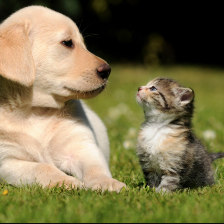
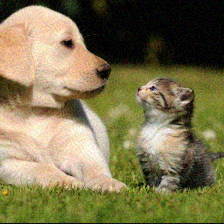

In [32]:
adv_image, acts, adv_acts, diff_acts = googlenet_adversarial_ifgsm("mixed4d", 
                                                                   img, 
                                                                   target_label="Indian cobra")

# Activation Grid Comparison

Here, we expose a function to generate [activation grids](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/building-blocks/ActivationGrid.ipynb) for each input image. These activation grids are maximizing the dot product between an input image's activations and the test activation vector. They represent a way to see what the network "sees" with a particular input. 

In [0]:
def render_activation_grid_less_naive(img, model, layer="mixed4d", W=42,
                                 n_groups=6, subsample_factor=1, n_steps=256):
  
  # Get the activations
  with tf.Graph().as_default(), tf.Session() as sess:
    t_input = tf.placeholder("float32", [None, None, None, 3])
    T = render.import_model(model, t_input, t_input)
    acts = T(layer).eval({t_input: img[None]})[0]
  acts_flat = acts.reshape([-1] + [acts.shape[2]])
  N = acts_flat.shape[0]
  
  # The trick to avoiding "decoherence" is to recognize images that are
  # for similar activation vectors and 
  if n_groups > 0:
    reducer = ChannelReducer(n_groups, "NMF")
    groups = reducer.fit_transform(acts_flat)
    groups /= groups.max(0)
  else:
    groups = np.zeros([])
    
  print groups.shape

  
  # The key trick to increasing memory efficiency is random sampling.
  # Even though we're visualizing lots of images, we only run a small
  # subset through the network at once. In order to do this, we'll need
  # to hold tensors in a tensorflow graph around the visualization process.
  
  with tf.Graph().as_default() as graph, tf.Session() as sess:
    
    
    # Using the groups, create a paramaterization of images that
    # partly shares paramters between the images for similar activation
    # vectors. Each one still has a full set of unique parameters, and could
    # optimize to any image. We're just making it easier to find solutions
    # where things are the same.
    group_imgs_raw = param.fft_image([n_groups, W, W, 3])
    unique_imgs_raw = param.fft_image([N, W, W, 3])
    opt_imgs = param.to_valid_rgb(tf.stack([
            0.7*unique_imgs_raw[i] + 
            0.5*sum(groups[i, j] * group_imgs_raw[j] for j in range(n_groups))
            for i in range(N) ]),
            decorrelate=True)
    
    # Construct a random batch to optimize this step
    batch_size = 64
    rand_inds = tf.random_uniform([batch_size], 0, N, dtype=tf.int32)
    pres_imgs = tf.gather(opt_imgs, rand_inds)
    pres_acts = tf.gather(acts_flat, rand_inds)
    obj = objectives.Objective.sum(
      [objectives.direction(layer, pres_acts[n], batch=n)
       for n in range(batch_size)
      ])
    
    # Actually do the optimization...
    T = render.make_vis_T(model, obj, param_f=pres_imgs)
    tf.global_variables_initializer().run()
    
    for i in range(n_steps):
      T("vis_op").run()
    
    vis_imgs = opt_imgs.eval()
  # Combine the images and display the resulting grid
  print ""
  vis_imgs_ = vis_imgs.reshape(list(acts.shape[:2]) + [W, W, 3])
  vis_imgs_cropped = vis_imgs_[:, :, 2:-2, 2:-2, :]
  show(np.hstack(np.hstack(vis_imgs_cropped)))
  return vis_imgs_cropped

## Original Image Activation Grid 

(196, 6)




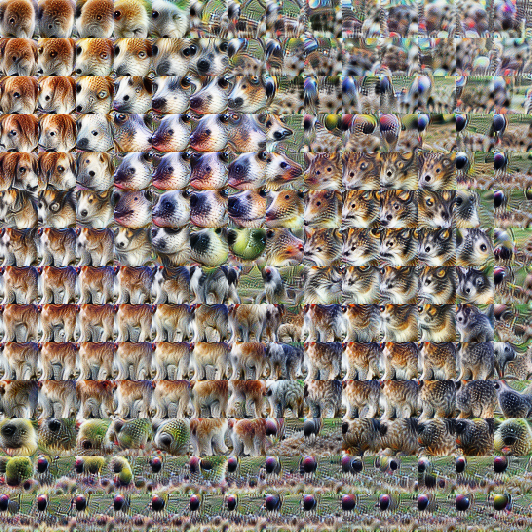

In [34]:
_m4d = render_activation_grid_less_naive(img, googlenet, layer="mixed4d", W=42, n_steps=1024)

## Adversarial Example Activation Grid 

Comparing the following activation grid for the adversarial example with the original, we can see that the network <i>sees</i> more textures and patterns resembling a snake (target = Indian cobra) than the previously seen snout, ears, and animal legs!

(196, 6)




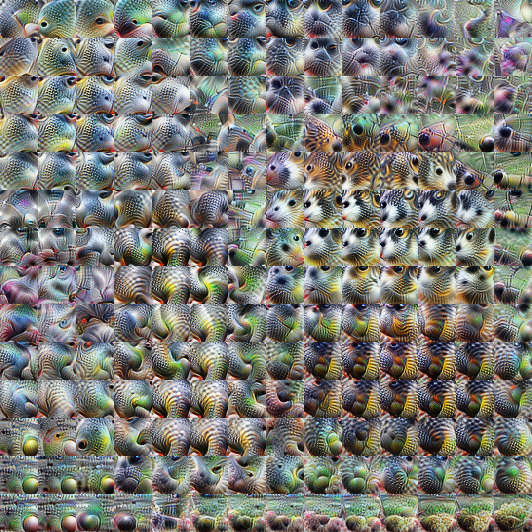

In [36]:
_m4d_adv = render_activation_grid_less_naive(adv_image, googlenet, layer="mixed4d", W=42, n_steps=1024)